# Transformer from Scratch: *Attention Is All You Need*

This notebook implements a Transformer model from scratch in PyTorch, based on the paper 'Attention Is All You Need'.


**Note:**  if you're:

- Downloading a dataset from the internet using commands like `wget`, `curl`, or Python libraries
- Loading a dataset from repositories like *Kaggle*, *Hugging Face*, or *TensorFlow* Datasets
- Using *API* calls to fetch data

All of these operations use Google's internet connection and are downloaded directly to the Colab virtual machine. The data is stored temporarily in the Colab instance's storage space, not on your local machine.

In [1]:
!pip install datasets sentencepiece
!pip install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


In [ ]:
# Install required libraries if not already installed
!pip install datasets sentencepiece
!pip install torch ==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install torchtext ==0.15.1


In [2]:

from datasets import load_dataset
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import nltk.translate.bleu_score as bleu
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math

import matplotlib.pyplot as plt
import math
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:

full_dataset = load_dataset("opus_books", "en-nl", split="train")  # or iwslt2017
splits = full_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = splits["train"]
val_dataset   = splits["test"]

SRC_LANGUAGE = "nl"
TGT_LANGUAGE = "en"

special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

def build_vocab(dataset, lang):
    counter = Counter()
    for item in dataset:
        counter.update(word_tokenize(item['translation'][lang]))
    vocab = {sym: i for i, sym in enumerate(special_symbols)}
    for word in counter:
        if word not in vocab:
            vocab[word] = len(vocab)
    return vocab

# Build vocab on full data (or just training set)
src_vocab = build_vocab(full_dataset, "nl")
tgt_vocab = build_vocab(full_dataset, "en")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-nl/train-00000-of-00001.parquet:   0%|          | 0.00/6.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38652 [00:00<?, ? examples/s]

In [4]:

# Tokenize and index helpers
def tokenize(text):
    return word_tokenize(text.lower())

def encode(text, vocab):
    return [vocab.get(tok, UNK_IDX) for tok in tokenize(text)]

# Collate function to prepare batches
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for item in batch:
        # Tokenize and numerify source sentence (Dutch)
        src_indices = encode(item['translation'][SRC_LANGUAGE], src_vocab)
        src_tensor = torch.tensor([BOS_IDX] + src_indices + [EOS_IDX], dtype=torch.long)
        src_batch.append(src_tensor)

        # Tokenize and numerify target sentence (English)
        tgt_indices = encode(item['translation'][TGT_LANGUAGE], tgt_vocab)
        tgt_tensor = torch.tensor([BOS_IDX] + tgt_indices + [EOS_IDX], dtype=torch.long)
        tgt_batch.append(tgt_tensor)

    # Pad sequences
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)
    return src_batch, tgt_batch


In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [7]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create matrix of shape (max_len, d_model) with positional encoding vectors
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        # Compute the div term: 10000^{-2i/d_model} for even i
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0) / d_model))
        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)  # 0,2,4,... dims
        pe[:, 1::2] = torch.cos(position * div_term)  # 1,3,5,... dims
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model) to allow broadcasting
        self.register_buffer('pe', pe)  # register as buffer so it’s saved with model and on same device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        # Add positional encoding up to seq_len
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)


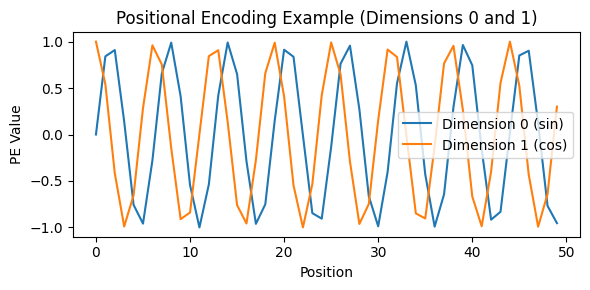

In [8]:

# Instantiate PositionalEncoding for a small d_model (e.g., 16) to visualize
pos_enc = PositionalEncoding(d_model=16, dropout=0.0, max_len=100)
pos_enc_values = pos_enc.pe[0, :50, :].cpu().tolist()  # first 50 positions, all 16 dims

plt.figure(figsize=(6,3))
# Plot positional encoding for dimension 0 and 1 (index 0: sin wave, index 1: cos wave)
pos_enc_values = np.array(pos_enc_values)

plt.plot(pos_enc_values[:, 0], label="Dimension 0 (sin)")
plt.plot(pos_enc_values[:, 1], label="Dimension 1 (cos)")
plt.title("Positional Encoding Example (Dimensions 0 and 1)")
plt.xlabel("Position")
plt.ylabel("PE Value")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:

def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: torch.Tensor = None):
    # Q, K, V shape: (batch, heads, seq_len_q, d_k), (batch, heads, seq_len_k, d_k), ...
    d_k = Q.size(-1)
    # 1. Compute raw attention scores by dot product
    # scores shape: (batch, heads, seq_len_q, seq_len_k)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    # 2. Apply mask (if provided) by setting scores to -inf where mask is True
    if mask is not None:
        scores = scores.masked_fill(~mask, -1e9)

    # Subtract the max for numerical stability.
    scores = scores - scores.max(dim=-1, keepdim=True)[0]
    # 3. Softmax to get attention weights
    attn_weights = F.softmax(scores, dim=-1)  # along seq_len_k
    # 4. Use weights to get weighted sum of values
    output = torch.matmul(attn_weights, V)  # shape: (batch, heads, seq_len_q, d_k)
    return output, attn_weights


In [10]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Learned projection matrices
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # For analysis, we can store attention weights if needed
        self.attn_weights = None

    def forward(self, Q_in: torch.Tensor, K_in: torch.Tensor, V_in: torch.Tensor, mask: torch.Tensor = None):
        batch_size = Q_in.size(0)
        # 1. Linear projections
        Q = self.W_q(Q_in)  # shape: (batch, seq_len_q, d_model)
        K = self.W_k(K_in)  # shape: (batch, seq_len_k, d_model)
        V = self.W_v(V_in)  # shape: (batch, seq_len_k, d_model)
        # 2. Reshape and split into heads
        # New shape: (batch, seq_len_q, n_heads, d_k) then permute
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        # 3. Apply scaled dot-product attention (with heads as batch dimension)
        if mask is not None:
            # mask shape expected: (batch, 1, seq_q, seq_k) or (batch, n_heads, seq_q, seq_k)
            # Expand mask to include head dimension if needed
            if mask.size(1) == 1 and mask.size(0) == batch_size:
                mask = mask.expand(batch_size, self.n_heads, mask.size(2), mask.size(3))
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        # 4. Concatenate heads and project
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()  # back to (batch, seq_len_q, n_heads, d_k)
        '''However, under the hood, permute() does not rearrange the actual data in memory.
        It just gives you a view with a new dimension order (by changing how indices are interpreted),
        which means the data is now non-contiguous in memory.'''

        attn_output = attn_output.view(batch_size, -1, self.d_model)  # (batch, seq_len_q, d_model)
        output = self.W_o(attn_output)
        output = self.dropout(output)
        # Store attention weights for possible visualization (concatenate heads or take first head)
        self.attn_weights = attn_weights  # shape: (batch, n_heads, seq_len_q, seq_len_k)
        return output


In [11]:

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch, seq_len, d_model)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


In [12]:

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        # Self-attention sub-layer
        attn_output = self.self_attn(x, x, x, mask=src_mask)
        x = x + attn_output  # add residual
        x = self.norm1(x)    # layer norm
        # Feed-forward sub-layer
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)  # add residual
        x = self.norm2(x)
        return x


In [13]:

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, enc_output: torch.Tensor, tgt_mask: torch.Tensor = None, mem_mask: torch.Tensor = None):
        # 1. Decoder self-attention (mask out future tokens)
        attn_output = self.self_attn(x, x, x, mask=tgt_mask)
        x = x + attn_output
        x = self.norm1(x)
        # 2. Encoder-Decoder cross-attention (queries = x, keys/values = enc_output)
        attn_output = self.cross_attn(x, enc_output, enc_output, mask=mem_mask)
        x = x + attn_output
        x = self.norm2(x)
        # 3. Position-wise feed-forward
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm3(x)
        return x


In [14]:

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, d_model: int = 256, n_heads: int = 4,
                 num_encoder_layers: int = 3, num_decoder_layers: int = 3, d_ff: int = 512, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        # Embedding layers
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        # Encoder and Decoder stacks
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_encoder_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_decoder_layers)])
        # Final output linear layer
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor = None):
        # src: [batch, src_len] (token indices)
        x = self.src_emb(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x  # shape: [batch, src_len, d_model]

    def decode(self, tgt: torch.Tensor, enc_output: torch.Tensor, tgt_mask: torch.Tensor = None, mem_mask: torch.Tensor = None):
        # tgt: [batch, tgt_len], enc_output: [batch, src_len, d_model]
        x = self.tgt_emb(tgt) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.decoder_layers:
            x = layer(x, enc_output, tgt_mask, mem_mask)
        return x  # shape: [batch, tgt_len, d_model]

    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: torch.Tensor = None,
                tgt_mask: torch.Tensor = None, mem_mask: torch.Tensor = None):
        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, tgt_mask, mem_mask)
        logits = self.fc_out(dec_output)  # raw logits for each token in tgt sequence
        return logits


In [15]:

# Instantiate a small transformer for testing
test_model = TransformerModel(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=32,
    n_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    d_ff=64
)

# Dummy input batch (Dutch source and English target)
dummy_src = torch.tensor([[BOS_IDX, 5, 6, 7, EOS_IDX, PAD_IDX, PAD_IDX]], dtype=torch.long)  # [1, 7]
dummy_tgt = torch.tensor([[BOS_IDX, 10, 11, EOS_IDX, PAD_IDX]], dtype=torch.long)            # [1, 5]

# Create masks for dummy input
def generate_masks(src, tgt):
    # No source future mask (can attend to all)
    src_pad_mask = (src == PAD_IDX).unsqueeze(1).unsqueeze(2)  # shape [batch, 1, 1, src_len]

    # Target future mask (prevent looking ahead)
    tgt_len = tgt.size(1)
    future_mask = torch.triu(torch.ones((tgt_len, tgt_len), dtype=torch.bool), diagonal=1)
    future_mask = future_mask.unsqueeze(0).unsqueeze(0)  # shape [1, 1, tgt_len, tgt_len]

    # Target pad mask (prevent attending to <pad>)
    tgt_pad_mask = (tgt == PAD_IDX).unsqueeze(1).unsqueeze(3)  # shape [batch, 1, tgt_len, 1]

    # Combine both masks
    tgt_mask = future_mask | tgt_pad_mask  # broadcasted to [batch, 1, tgt_len, tgt_len]

    # Memory mask for encoder-decoder attention (prevent decoder from attending to <pad> in encoder)
    mem_mask = src_pad_mask  # shape [batch, 1, 1, src_len]

    return src_pad_mask, tgt_mask, mem_mask

# Generate masks
src_mask, tgt_mask, mem_mask = generate_masks(dummy_src, dummy_tgt)

# Forward pass
out_logits = test_model(dummy_src, dummy_tgt, src_mask, tgt_mask, mem_mask)

# Output shape
print("Output logits shape:", out_logits.shape)  # Expecting [1, 5, tgt_vocab_size]


Output logits shape: torch.Size([1, 5, 30060])


In [16]:

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Instantiate the Transformer model
d_model = 256   # embedding dimension
n_heads = 8     # number of attention heads
d_ff = 512      # feed-forward inner layer dimension
num_layers = 4  # number of encoder and decoder layers
model = TransformerModel(len(src_vocab),
                         len(tgt_vocab),
                         d_model=d_model, n_heads=n_heads,
                         num_encoder_layers=num_layers, num_decoder_layers=num_layers,
                         d_ff=d_ff, dropout=0.1).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Function to create masks for a batch
def create_masks(src: torch.Tensor, tgt: torch.Tensor):
    """
    src: [batch, src_len], tgt: [batch, tgt_len] with BOS and EOS included in tgt.
    Returns src_mask, tgt_mask, mem_mask.
    """
    batch_size, src_len = src.size()
    tgt_len = tgt.size(1)
    # Encoder (src) padding mask: shape [batch, 1, 1, src_len]
    src_pad_mask = (src == PAD_IDX).unsqueeze(1).unsqueeze(2)  # True where pad
    # Decoder (tgt) padding mask for keys:
    tgt_pad_mask = (tgt == PAD_IDX).unsqueeze(1).unsqueeze(3)  # [batch, 1, tgt_len, 1]
    # Subsequent mask for decoder (to mask future positions)
    # shape [tgt_len, tgt_len]: True where j>i
    future_mask = torch.triu(torch.ones((tgt_len, tgt_len), device=device, dtype=torch.bool), diagonal=1)
    future_mask = future_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, tgt_len, tgt_len]
    # Combine tgt masks: mask out future and padded keys
    tgt_mask = future_mask | tgt_pad_mask  # broadcast over batch
    # For decoder cross-attention: mask out source pads for each target query
    mem_mask = src_pad_mask  # shape [batch, 1, 1, src_len] (will broadcast across tgt_len dimension in attention)
    return src_pad_mask, tgt_mask, mem_mask

# Training loop
NUM_EPOCHS = 10
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total_loss = 0
    for src_batch, tgt_batch in train_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        # Prepare target input and output
        tgt_in = tgt_batch[:, :-1]   # input to decoder (everything except last token)
        tgt_out = tgt_batch[:, 1:]   # target output (everything except first token <BOS>)
        # Create masks
        src_mask, tgt_mask, mem_mask = create_masks(src_batch, tgt_in)
        # Forward pass
        logits = model(src_batch, tgt_in, src_mask, tgt_mask, mem_mask)
        # Compute loss (flatten the logits and targets for cross-entropy)
        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.reshape(-1))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src_batch, tgt_batch in val_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            tgt_in = tgt_batch[:, :-1]
            tgt_out = tgt_batch[:, 1:]
            src_mask, tgt_mask, mem_mask = create_masks(src_batch, tgt_in)
            logits = model(src_batch, tgt_in, src_mask, tgt_mask, mem_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.reshape(-1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.3f}, Val Loss = {avg_val_loss:.3f}")


Using device: cuda
Epoch 1: Train Loss = 4.534, Val Loss = 3.008
Epoch 2: Train Loss = 2.676, Val Loss = 2.201
Epoch 3: Train Loss = 2.106, Val Loss = 1.894
Epoch 4: Train Loss = 1.845, Val Loss = 1.772
Epoch 5: Train Loss = 1.713, Val Loss = 1.689
Epoch 6: Train Loss = 1.636, Val Loss = 1.658
Epoch 7: Train Loss = 1.584, Val Loss = 1.645
Epoch 8: Train Loss = 1.550, Val Loss = 1.613
Epoch 9: Train Loss = 1.522, Val Loss = 1.603
Epoch 10: Train Loss = 1.503, Val Loss = 1.585


In [ ]:

# --- Corrected evaluation + BLEU computation ---
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smooth = SmoothingFunction().method1

# Ensure inverse vocab maps indices -> tokens
inv_tgt_vocab = {idx: tok for tok, idx in tgt_vocab.items()}

def translate_sentence(sentence: str, max_len: int = 50):
    model.eval()
    # numericalize and add BOS/EOS
    src_indices = [BOS_IDX] + encode(sentence, src_vocab) + [EOS_IDX]
    src = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)  # [1, src_len]
    # src padding mask (True where should be masked -- i.e., pad tokens)
    src_pad_mask = (src == PAD_IDX).unsqueeze(1).unsqueeze(2)  # [1,1,1,src_len] or similar for attention

    # Get encoder output
    with torch.no_grad():
        enc_output = model.encode(src, src_pad_mask)

        pred_indices = [BOS_IDX]
        for _ in range(max_len):
            tgt_tensor = torch.tensor(pred_indices, dtype=torch.long).unsqueeze(0).to(device)  # [1, tgt_len]
            # causal mask for decoder (prevent attention to future tokens)
            tgt_len = tgt_tensor.size(1)
            subsequent_mask = torch.triu(torch.ones((tgt_len, tgt_len), dtype=torch.bool, device=device), diagonal=1)
            # combine with padding mask for target (no padding here)
            tgt_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)  # shape [1,1,tgt_len,tgt_len]
            # Call decode -> returns [batch, tgt_len, d_model]
            dec_output = model.decode(tgt_tensor, enc_output, tgt_mask, None)
            logits = model.fc_out(dec_output)  # [1, tgt_len, vocab_size]
            next_token_logits = logits[0, -1, :]
            next_token = int(torch.argmax(next_token_logits).item())
            pred_indices.append(next_token)
            if next_token == EOS_IDX:
                break

    # map indices to tokens and remove special tokens
    tokens = [inv_tgt_vocab.get(idx, '<unk>') for idx in pred_indices if idx not in {BOS_IDX, EOS_IDX, PAD_IDX}]
    return " ".join(tokens)

def compute_bleu_on_dataset(dataset, num_sentences=100):
    references = []
    hypotheses = []
    count = 0
    for item in dataset:
        if count >= num_sentences:
            break
        src = item['translation'][SRC_LANGUAGE]
        tgt = item['translation'][TGT_LANGUAGE]
        pred_sent = translate_sentence(src, max_len=80)
        pred_tokens = pred_sent.split()
        ref_tokens = tokenize(tgt)
        hypotheses.append(pred_tokens)
        references.append([ref_tokens])  # list of reference lists
        count += 1
    score = corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)
    print(f"BLEU score on first {num_sentences} sentences: {score:.4f}")
    return score

# Run BLEU on first 100 of validation set if available
if 'val_dataset' in globals():
    compute_bleu_on_dataset(val_dataset, num_sentences=100)
elif 'full_dataset' in globals():
    # try using dataset split
    compute_bleu_on_dataset(full_dataset['test'] if 'test' in full_dataset else full_dataset, num_sentences=100)
else:
    print('No dataset found in workspace to evaluate BLEU.')


In [ ]:

# --- Show a few sample predictions vs references ---
def show_sample_predictions(dataset, num_samples=5):
    for i in range(num_samples):
        src = dataset[i]['translation'][SRC_LANGUAGE]
        tgt = dataset[i]['translation'][TGT_LANGUAGE]
        pred = translate_sentence(src, max_len=80)
        print(f"Source:      {src}")
        print(f"Reference:   {tgt}")
        print(f"Prediction:  {pred}")
        print("-" * 60)

if 'val_dataset' in globals():
    show_sample_predictions(val_dataset, num_samples=5)
elif 'full_dataset' in globals():
    data_split = full_dataset['test'] if 'test' in full_dataset else full_dataset
    show_sample_predictions(data_split, num_samples=5)
else:
    print("No dataset found for sample predictions.")
